In [1]:
# 신경 단어 벡터 시각화를 사용해 고차우너의 단어를 2차원으로 시각화

In [6]:
from __future__ import print_function

import os

In [10]:
#os.chdir("C:\\Users\\prata\\Documents\\book_codes\\NLP_DL")

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.stem import PorterStemmer

import string
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [16]:
def preprocessing(text):
    
    text2 = " ".join("".join([" " if ch in string.punctuation else ch for ch in text]).split())

    tokens = [word for sent in nltk.sent_tokenize(text2) for word in
              nltk.word_tokenize(sent)]
    
    tokens = [word.lower() for word in tokens]
    
    stopwds = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwds]
    
    tokens = [word for word in tokens if len(word)>=3]
    
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    tagged_corpus = pos_tag(tokens)    
    
    Noun_tags = ['NN','NNP','NNPS','NNS']
    Verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']

    lemmatizer = WordNetLemmatizer()

    def prat_lemmatize(token,tag):
        if tag in Noun_tags:
            return lemmatizer.lemmatize(token,'n')
        elif tag in Verb_tags:
            return lemmatizer.lemmatize(token,'v')
        else:
            return lemmatizer.lemmatize(token,'n')
    
    pre_proc_text =  " ".join([prat_lemmatize(token,tag) for token,tag in tagged_corpus])             

    return pre_proc_text

In [17]:
fin = open("alice_in_wonderland.txt", "rb")
lines = []

In [18]:
for line in fin:
    
#     line = line.strip().decode("ascii", "ignore").encode("utf-8")
#     print("b", line)
    
    line = line.strip().decode("ascii", "ignore")
    
    if len(line) == 0:
        continue
        
    lines.append(preprocessing(line))
    

In [19]:
fin.close()

In [20]:
lines # lines 내용 출력, 교재에는 없다.

['alic adventur wonderland',
 'alic adventur wonderland',
 'lewi carrol',
 'millennium fulcrum edit',
 'chapter',
 'rabbit hole',
 'alic begin get tire sit sister',
 'bank noth twice',
 'peep book sister read',
 'pictur convers use book',
 'think alic without pictur convers',
 'consid mind well could',
 'hot day make feel sleepi stupid whether',
 'pleasur make daisi chain would worth troubl',
 'get pick daisi suddenli white',
 'rabbit pink eye run close',
 'noth remark alic',
 'think much way hear rabbit say',
 'dear dear shall late think',
 'afterward occur ought',
 'wonder time seem quit natur',
 'rabbit actual take watch waistcoat',
 'pocket look hurri alic start',
 'foot flash across mind never',
 'see rabbit either waistcoat pocket watch',
 'take burn curio run across',
 'field fortun time see pop',
 'larg rabbit hole hedg',
 'anoth moment go alic never',
 'consid world get',
 'rabbit hole go straight like tunnel way',
 'dip suddenli suddenli alic',
 'moment think stop found',
 'f

In [21]:
import collections
counter = collections.Counter()

for line in lines:
    for word in nltk.word_tokenize(line):
        counter[word.lower()]+=1

word2idx = {w:(i+1) for i,(w,_) in enumerate(counter.most_common())}        
idx2word = {v:k for k,v in word2idx.items()}

In [22]:
xs = []
ys = []

for line in lines:
    embedding = [word2idx[w.lower()] for w in nltk.word_tokenize(line)] 
    triples = list(nltk.trigrams(embedding))
    w_lefts = [x[0] for x in triples]
    w_centers = [x[1] for x in triples]
    w_rights = [x[2] for x in triples]
    xs.extend(w_centers)
    ys.extend(w_lefts)
    xs.extend(w_centers)
    ys.extend(w_rights)

In [23]:
print (len(word2idx))

vocab_size = len(word2idx)+1
print(vocab_size)

1786
1787


In [24]:
# 인자 이름이 바뀐것을 알 수 있다.
# ohe = OneHotEncoder(n_values=vocab_size)
#그래서인지 결과도 1787L처럼 L이 붙어 있지 않다.
ohe = OneHotEncoder(categories=[range(vocab_size)])
X = ohe.fit_transform(np.array(xs).reshape(-1, 1)).todense()
Y = ohe.fit_transform(np.array(ys).reshape(-1, 1)).todense()
Xtrain, Xtest, Ytrain, Ytest,xstr,xsts = train_test_split(X, Y,xs, test_size=0.3,
                                                random_state=42)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(9707, 1787) (4161, 1787) (9707, 1787) (4161, 1787)


In [25]:
from keras.layers import Input,Dense,Dropout
from keras.models import Model

In [26]:
np.random.seed(42)

BATCH_SIZE = 128
NUM_EPOCHS = 20


input_layer = Input(shape = (Xtrain.shape[1],),name="input")
first_layer = Dense(300,activation='relu',name = "first")(input_layer)
first_dropout = Dropout(0.5,name="firstdout")(first_layer)

second_layer = Dense(2,activation='relu',name="second")(first_dropout)

third_layer = Dense(300,activation='relu',name="third")(second_layer)
third_dropout = Dropout(0.5,name="thirdout")(third_layer)

fourth_layer = Dense(Ytrain.shape[1],activation='softmax',name = "fourth")(third_dropout)


history = Model(input_layer,fourth_layer)
history.compile(optimizer = "rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

In [27]:
history.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,epochs=NUM_EPOCHS, verbose=1,validation_split = 0.2) 
# 모델 학습 , 시간이 조금 걸린다.
# 0x2855603bbb0, 교재와는 다른 값으로 결과도 살짝 다르다

Epoch 1/20
61/61 [==============================] - 3s 53ms/step - loss: 6.9142 - accuracy: 0.0422 - val_loss: 6.4381 - val_accuracy: 0.0479
Epoch 2/20
61/61 [==============================] - 2s 35ms/step - loss: 6.3941 - accuracy: 0.0426 - val_loss: 6.4467 - val_accuracy: 0.0479
Epoch 3/20
61/61 [==============================] - 2s 32ms/step - loss: 6.3477 - accuracy: 0.0435 - val_loss: 6.4724 - val_accuracy: 0.0479
Epoch 4/20
61/61 [==============================] - 2s 34ms/step - loss: 6.3271 - accuracy: 0.0429 - val_loss: 6.5017 - val_accuracy: 0.0479
Epoch 5/20
61/61 [==============================] - 2s 34ms/step - loss: 6.3046 - accuracy: 0.0439 - val_loss: 6.5234 - val_accuracy: 0.0479
Epoch 6/20
61/61 [==============================] - 2s 38ms/step - loss: 6.2983 - accuracy: 0.0438 - val_loss: 6.5485 - val_accuracy: 0.0479
Epoch 7/20
61/61 [==============================] - 3s 45ms/step - loss: 6.2866 - accuracy: 0.0439 - val_loss: 6.5528 - val_accuracy: 0.0479
Epoch 8/20
61

In [28]:
# 잠재 변수 예측을 위해 모델의 인코더 부분 추출
encoder = Model(history.input,history.get_layer("second").output)

In [29]:
# 추출된 인코더 모델을 사용해 잠재 변수 예측
reduced_X = encoder.predict(Xtest)

In [30]:
# 더 나은 표현을 위해 출력을 Pandas 데이터 프레임 구조로 변환
final_pdframe = pd.DataFrame(reduced_X)
final_pdframe.columns = ["xaxis","yaxis"]
final_pdframe["word_indx"] = xsts
final_pdframe["word"] = final_pdframe["word_indx"].map(idx2word)

In [31]:
# rows = random.sample(final_pdframe.index, 100) // error
# 버전이 바뀌면서 달라진 함수
rows = random.sample(list(final_pdframe.index), 100)

In [32]:
# 위와 마찬가지
# vis_df = final_pdframe.ix[rows] // error

# vis_df = final_pdframe.ix[rows] # 1
vis_df = final_pdframe.loc[rows] # 2

labels = list(vis_df["word"])
xvals = list(vis_df["xaxis"])
yvals = list(vis_df["yaxis"])

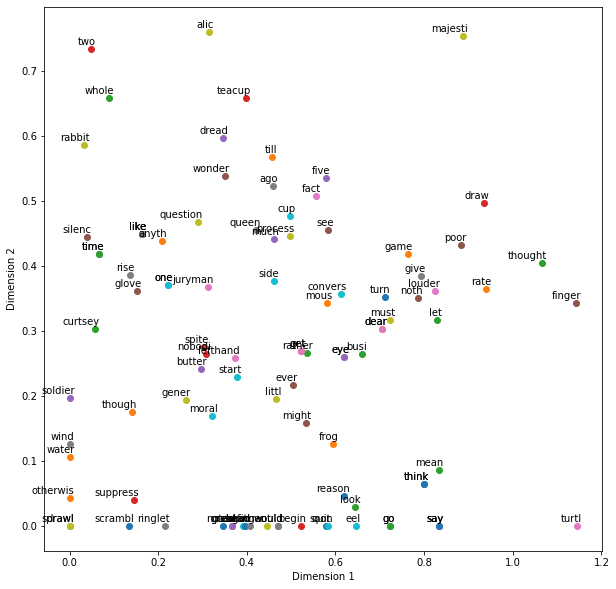

In [33]:
# 인치 단위
plt.figure(figsize=(10, 10))  

for i, label in enumerate(labels):
    x = xvals[i]
    y = yvals[i]
    plt.scatter(x, y)
    plt.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points',
                 ha='right',va='bottom')

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()
# 여기서 나타나는 그래프가 교재뿐만이 아니라 올려주신 pdf와도 매우 다르다.